# Notebook para o PAN - Atribuição Autoral - 2018

In [56]:
%matplotlib inline
#python basic libs
from __future__ import print_function

from tempfile import mkdtemp
from shutil import rmtree
import os;
from os.path import join as pathjoin;

import re;
import glob;
import json;
import codecs;
from collections import defaultdict;
import pprint;


from pprint import pprint
from time import time
import logging


#data analysis libs
import numpy as np;
import pandas as pd;
import matplotlib.pyplot as plt;
import random;

#machine learning libs
#feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#preprocessing and transformation
from sklearn.preprocessing import normalize, Normalizer, MaxAbsScaler, MinMaxScaler;
from sklearn.preprocessing import LabelBinarizer;
from sklearn.decomposition import PCA;
from sklearn.metrics.pairwise import cosine_similarity;


from sklearn.base import BaseEstimator, ClassifierMixin

#classifiers
from sklearn.svm import LinearSVC, SVC
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.feature_selection import RFE,SelectFpr,SelectPercentile, chi2;

#
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#model valuation
from sklearn.model_selection import train_test_split;
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score;

In [2]:
import platform; print(platform.platform())
print("NumPy", np.__version__)
import scipy; print("SciPy", scipy.__version__)
import sklearn; print("Scikit-Learn", sklearn.__version__)

Darwin-17.4.0-x86_64-i386-64bit
NumPy 1.14.2
SciPy 1.0.1
Scikit-Learn 0.19.1


### paths configuration

In [3]:
baseDir = '/Users/joseeleandrocustodio/Dropbox/mestrado/02 - Pesquisa/code';

inputDir= pathjoin(baseDir,'pan18aa');
outputDir= pathjoin(baseDir,'out',"oficial");
if not os.path.exists(outputDir):
    os.mkdir(outputDir);

## loading the dataset

In [4]:
def readCollectionsOfProblems(path):
    # Reading information about the collection
    infocollection = path+os.sep+'collection-info.json'
    with open(infocollection, 'r') as f:
        problems  = [
            {
                'problem': attrib['problem-name'],
                'language': attrib['language'],
                'encoding': attrib['encoding'],
            }
            for attrib in json.load(f)
            
        ]
    return problems;

In [5]:
problems = readCollectionsOfProblems(inputDir);

In [6]:
problems[0]

{'encoding': u'UTF-8', 'language': u'en', 'problem': u'problem00001'}

In [7]:
def readProblem(path, problem):
    # Reading information about the problem
    infoproblem = path+os.sep+problem+os.sep+'problem-info.json'
    candidates = []
    with open(infoproblem, 'r') as f:
        fj = json.load(f)
        unk_folder = fj['unknown-folder']
        for attrib in fj['candidate-authors']:
            candidates.append(attrib['author-name'])
    return unk_folder, candidates;

In [8]:
def read_files(path,label):
    # Reads all text files located in the 'path' and assigns them to 'label' class
    files = glob.glob(pathjoin(path,label,'*.txt'))
    texts=[]
    for i,v in enumerate(files):
        f=codecs.open(v,'r',encoding='utf-8')
        texts.append((f.read(),label, os.path.basename(v)))
        f.close()
    return texts

In [9]:
for index,problem in enumerate(problems):
    unk_folder, candidates_folder = readProblem(inputDir, problem['problem']); 
    problem['candidates_folder_count'] = len(candidates_folder);
    problem['candidates'] = [];
    for candidate in candidates_folder:
        problem['candidates'].extend(read_files(pathjoin(inputDir, problem['problem']),candidate));
    
    problem['unknown'] = read_files(pathjoin(inputDir, problem['problem']),unk_folder);    

In [10]:
pd.DataFrame(problems)

,candidates,candidates_folder_count,encoding,language,problem,unknown
0,"[(graceful ones.\n\n""One more,"" Marvelous said...",20,UTF-8,en,problem00001,"[(after all, his best friends. And what in the..."
1,"[(a mission.""\n\nJensen just raises an eyebrow...",5,UTF-8,en,problem00002,"[(“Potter was attractive,” Draco thought, sigh..."
2,[(qui l'avait tué mais tout était de la faute ...,20,UTF-8,fr,problem00003,[(son réveil. Sa main pulse et Draco frotte l'...
3,[(. Le canapé est vide et lorsqu'il passe deva...,5,UTF-8,fr,problem00004,"[(abasourdie.\n\nTout d'abord, elle crut que s..."
4,"[(Eppure lui la mappa l’aveva stampata, dannaz...",20,UTF-8,it,problem00005,[(– Oh. Cazzo.\nSirius era così sconvolto che ...
5,[(Yato ha trovato una lettera sul suo comodino...,5,UTF-8,it,problem00006,"[(così la tua vista, Moony?\n– Cercavo di esse..."
6,[(zmienił zdanie. Niech się stworzonko pobawi....,20,UTF-8,pl,problem00007,"[(dawniej pełna radości i ciepła, a teraz wiec..."
7,"[(Słowem, które Sherlock najczęściej słyszał w...",5,UTF-8,pl,problem00008,"[(, uderzającego o żebra niczym dzwon- niemal ..."
8,[(pero no lo ama como ama a Guignol –explicó e...,20,UTF-8,sp,problem00009,[(–La nariz puntiaguda del elfo casi rozaba el...
9,"[(incapaz de señalar un momento exacto, un pun...",5,UTF-8,sp,problem00010,[(tan parecidas hizo que su trasero latiese de...


In [11]:
#*******************************************************************************************************
import warnings
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import LabelEncoder


def eval_measures(gt, pred):
    """Compute macro-averaged F1-scores, macro-averaged precision, 
    macro-averaged recall, and micro-averaged accuracy according the ad hoc
    rules discussed at the top of this file.
    Parameters
    ----------
    gt : dict
        Ground truth, where keys indicate text file names
        (e.g. `unknown00002.txt`), and values represent
        author labels (e.g. `candidate00003`)
    pred : dict
        Predicted attribution, where keys indicate text file names
        (e.g. `unknown00002.txt`), and values represent
        author labels (e.g. `candidate00003`)
    Returns
    -------
    f1 : float
        Macro-averaged F1-score
    precision : float
        Macro-averaged precision
    recall : float
        Macro-averaged recall
    accuracy : float
        Micro-averaged F1-score
    """

    actual_authors = list(gt.values())
    encoder = LabelEncoder().fit(['<UNK>'] + actual_authors)

    text_ids, gold_authors, silver_authors = [], [], []
    for text_id in sorted(gt):
        text_ids.append(text_id)
        gold_authors.append(gt[text_id])
        try:
            silver_authors.append(pred[text_id])
        except KeyError:
            # missing attributions get <UNK>:
            silver_authors.append('<UNK>')

    assert len(text_ids) == len(gold_authors)
    assert len(text_ids) == len(silver_authors)

    # replace non-existent silver authors with '<UNK>':
    silver_authors = [a if a in encoder.classes_ else '<UNK>' 
                      for a in silver_authors]

    gold_author_ints   = encoder.transform(gold_authors)
    silver_author_ints = encoder.transform(silver_authors)

    # get F1 for individual classes (and suppress warnings):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        f1 = f1_score(gold_author_ints,
                  silver_author_ints,
                  labels=list(set(gold_author_ints)),
                  average='macro')
        precision = precision_score(gold_author_ints,
                  silver_author_ints,
                  labels=list(set(gold_author_ints)),
                  average='macro')
        recall = recall_score(gold_author_ints,
                  silver_author_ints,
                  labels=list(set(gold_author_ints)),
                  average='macro')
        accuracy = accuracy_score(gold_author_ints,
                  silver_author_ints)

    return f1,precision,recall,accuracy


In [12]:
def evaluate(ground_truth_file,predictions_file):
    # Calculates evaluation measures for a single attribution problem
    gt = {}
    with open(ground_truth_file, 'r') as f:
        for attrib in json.load(f)['ground_truth']:
            gt[attrib['unknown-text']] = attrib['true-author']

    pred = {}
    with open(predictions_file, 'r') as f:
        for attrib in json.load(f):
            if attrib['unknown-text'] not in pred:
                pred[attrib['unknown-text']] = attrib['predicted-author']
    f1,precision,recall,accuracy =  eval_measures(gt,pred)
    return f1, precision, recall, accuracy

In [13]:
from sklearn.base import BaseEstimator
from scipy.sparse import issparse


class DenseTransformer(BaseEstimator):
    """Convert a sparse array into a dense array."""

    def __init__(self, return_copy=True):
        self.return_copy = return_copy
        self.is_fitted = False

    def transform(self, X, y=None):
        if issparse(X):
            return X.toarray()
        elif self.return_copy:
            return X.copy()
        else:
            return X

    def fit(self, X, y=None):
        self.is_fitted = True
        return self

    def fit_transform(self, X, y=None):
        return self.transform(X=X, y=y)

In [14]:
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

In [15]:
class DistanceClassifier(BaseEstimator, ClassifierMixin):  
    """A classifier that uses classes embeddings to classify instances"""
    
    def __init__(
            self,
            ngram = (3,4),
            analyzer = 'char',
            min_df = 0.3,
            max_df = 1.0
        ):
        """
        Called when initializing the classifier
        """
        self.analyzer      = analyzer
        self.vocabulary_   = {}
        self.ngram         = ngram
        self.min_df        = min_df
        self.max_df        = max_df

        
    def fit(self, X, y=None):
        """
        Sumarize one text per labels and transform the text into word vectors
        """
        
        #creating author profile
        profile = defaultdict(unicode);
        for text, label in zip(X,y):
            profile[label]+=text;
            
        #build a global vocaculary / Using count vectorizer to create a fixed vocabulary
        vectorizer = TfidfVectorizer(
                analyzer=self.analyzer,
                ngram_range=self.ngram,
                min_df=self.min_df,
                max_df=self.max_df,
                lowercase=False
        )
        vectorizer.fit(X);
        self.vectorizer_ = vectorizer
        
        # profile vector represent each author in the embedding space
        self.profileVectors_ = {y: vectorizer.transform(profile[y]) for y in y};

        return self
    
    
    def _minmax(self, a):
        a = (a - a.min())/(a.max() - a.min());
        return a;
        
    def _simpleCosine(self,a, b):
        '''
        calculates cosine between array a and b.
        This function is used because sklearn similiraty function compares all elements vs all elements
        what will not be used. So this function becames handy.
        '''
        a = a / np.sqrt(np.sum(a **2));
        b = b / np.sqrt(np.sum(b **2));
        cos = np.sum(np.array(a) * np.array(b));
        return cos;
    
    def _KLD(self,p, q):
        p = self._minmax(p); p = p/p.sum();
        q = self._minmax(q); q = q/q.sum();
        
        cond = ((q != 0)&(p != 0));
        k1 = np.sum(np.where(cond, p * np.log(p / q), 0));
        return k1;
    
    def _manhattan(self,p, q):
        p = self._minmax(p); p = p/p.sum();
        q = self._minmax(q); q = q/q.sum();
        return np.mean(np.abs(p-q));
    
    
    def _guassian(self, C,D):
        cond = C-D !=0;
        bc = np.where(cond,(C-D+1)**2/(2*np.maximum(C,D+1)),1);
        return np.sum(-np.log(bc));


    def score(self, X, y=None):
        # counts number of values bigger than mean
        return(sum(self.predict(X)))
    
    def _softMax(self,a):
        a = self._minmax(a);
        a = np.exp(a)/np.sum(np.exp(a))
        return a;
    
    def _predict1Doc(self, docVect):
        metrics = [];
        
        def c(aa,bb, funct):
            voc = set(aa.vocab.keys()) & set(bb.vocab.keys())
            f = np.array([
                funct(aa[v], bb[v])
                for v in voc
            ]);
            f = np.sum(f)
            return f;
    
        for label in self.profileVectors_:
            labelVocab = set(self.profileVectors_[label].vocab.keys());
            intersect  = vocabDoc & labelVocab;
            union      = len(vocabDoc | labelVocab);
            jaccard    = 1.0*len(intersect) / union;
            
            metrics.append({
                'label'       : label,
                'jaccard'     : jaccard,
                'lenIntersect': len(intersect),
                'lenUnion'    : union,
                'lenMax'      : max(len(labelVocab), len(vocabDoc)),
                'similarity'  : c(docVect, self.profileVectors_[label], self._simpleCosine),
                'KLD'         : c(docVect, self.profileVectors_[label], self._KLD),
                'manhattan'   : c(docVect, self.profileVectors_[label], self._manhattan),
                'guassian'    : c(docVect, self.profileVectors_[label], self._guassian),
                
            })
        #softmax norm
        similarity = self._softMax(np.array([c['similarity'] for c in metrics ]));
        guassian   = self._softMax(np.array([c['guassian'] for c in metrics ]));
        manhattan  = self._softMax(np.array([c['manhattan'] for c in metrics ]));
    
        #appending normalized sum of distance
        for i,c in enumerate(metrics):
            c.update({
                'similarityNorm': similarity[i],
                'guassianNorm': guassian[i],
                'manhattanNorm': manhattan[i]
            })
    
        return metrics;
    
    def predict(self, X, y=None):
        try:
            getattr(self, "profileVectors_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
            
        docVectors    = vectorizer.transform(X);
        self.metrics_ = [self._predict1Doc(v)      for v in docVectors];
        
        result = [];
        for r in self.metrics_:
            best = r[0];
            best['bestMatch'] = True;
            for rr in r:
                if rr != best:
                    rr['bestMatch'] = False;
                if rr['similarityNorm'] > best['similarityNorm'] :
                    best['bestMatch'] = False;
                    best = rr;
                    best['bestMatch'] = True;
            result.append(best);
            
        self.predited_ = result;

        return([r['label'] for r in result])

In [20]:
def runML(problem):
    print ("\nProblem: %s,  language: %s, " %(problem['problem'],problem['language']))
    
    train_docs, train_labels, _   = zip(*problem['candidates'])
    problem['training_docs_size'] = len(train_docs);
    test_docs, _, test_filename   = zip(*problem['unknown'])
    
    cachedir = mkdtemp()
    pipeline = Pipeline([
        ('vect',   TfidfVectorizer(analyzer='word',max_df=1.0, min_df=0.05, norm='l2', sublinear_tf=True)),
        ('dense',  DenseTransformer()),
        ('scaler', MinMaxScaler()),
        ('selector', SelectFromModel(LinearSVC(C=0.9, penalty="l1", dual=False))),
        ('transf', PCA(0.99)),
        ('clf', LogisticRegression(random_state=0,multi_class='multinomial', solver='newton-cg')),
    ], memory=cachedir)
    
    
    # uncommenting more parameters will give better exploring power but will
    # increase processing time in a combinatorial way
    parameters = {
        'transf__n_components': (0.1,0.5,0.9,0.99),
    }
    
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
    
    print("Performing grid search...")
    t0 = time()
    grid_search.fit(train_docs, train_labels)
    print("done in %0.3fs" % (time() - t0))

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    train_pred=grid_search.predict(train_docs);
    test_pred=grid_search.predict(test_docs);
    
    
    # Writing output file
    out_data=[]
    for i,v in enumerate(test_pred):
        out_data.append(
                {'unknown-text': test_filename[i],
                 'predicted-author': v
                }
                )
    answerFile = pathjoin(outputDir,'answers-'+problem['problem']+'.json');
    with open(answerFile, 'w') as f:
        json.dump(out_data, f, indent=4)
        #allProblems.extend(out_data)
    
    
    #evaluation train
    f1,precision,recall,accuracy=evaluate(
                pathjoin(inputDir, problem['problem'], 'ground-truth.json'),
                answerFile)
    rmtree(cachedir)
    return {
                'problem-name'   : problem['problem'],
                "train_doc_size":len(train_docs),
                "language":problem['language'],
                'macro-f1'       : round(f1,3),
                'macro-precision': round(precision,3),
                'macro-recall'   : round(recall,3),
                'micro-accuracy' : round(accuracy,3),
                'AuthorCount':len(set(train_labels))
        };

In [21]:
result = [];
for problem in problems:
    result.append(runML(problem));
pd.DataFrame(result)


Problem: problem00001,  language: en, 
Performing grid search...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    2.0s finished


done in 2.781s
Best score: 0.443
Best parameters set:
	transf__n_components: 0.99

Problem: problem00002,  language: en, 
Performing grid search...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.9s finished


done in 1.215s
Best score: 0.743
Best parameters set:
	transf__n_components: 0.9

Problem: problem00003,  language: fr, 
Performing grid search...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    1.9s finished


done in 2.650s
Best score: 0.486
Best parameters set:
	transf__n_components: 0.99

Problem: problem00004,  language: fr, 
Performing grid search...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.8s finished


done in 1.214s
Best score: 0.743
Best parameters set:
	transf__n_components: 0.9

Problem: problem00005,  language: it, 
Performing grid search...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    2.0s finished


done in 2.829s
Best score: 0.464
Best parameters set:
	transf__n_components: 0.99

Problem: problem00006,  language: it, 
Performing grid search...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    1.0s finished


done in 1.332s
Best score: 0.629
Best parameters set:
	transf__n_components: 0.9

Problem: problem00007,  language: pl, 
Performing grid search...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    2.3s finished


done in 3.194s
Best score: 0.586
Best parameters set:
	transf__n_components: 0.5

Problem: problem00008,  language: pl, 
Performing grid search...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    1.3s finished


done in 1.714s
Best score: 0.600
Best parameters set:
	transf__n_components: 0.9

Problem: problem00009,  language: sp, 
Performing grid search...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    2.1s finished


done in 2.848s
Best score: 0.629
Best parameters set:
	transf__n_components: 0.99

Problem: problem00010,  language: sp, 
Performing grid search...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    1.3s finished


done in 1.817s
Best score: 0.743
Best parameters set:
	transf__n_components: 0.5


,AuthorCount,language,macro-f1,macro-precision,macro-recall,micro-accuracy,problem-name,train_doc_size
0,20,en,0.333,0.337,0.501,0.457,problem00001,140
1,5,en,0.464,0.423,0.550,0.714,problem00002,35
2,20,fr,0.336,0.372,0.399,0.429,problem00003,140
3,5,fr,0.517,0.576,0.557,0.667,problem00004,35
4,20,it,0.373,0.369,0.517,0.487,problem00005,140
5,5,it,0.437,0.463,0.555,0.587,problem00006,35
6,20,pl,0.262,0.253,0.357,0.291,problem00007,140
7,5,pl,0.563,0.683,0.667,0.467,problem00008,35
8,20,sp,0.494,0.480,0.584,0.573,problem00009,140
9,5,sp,0.372,0.416,0.359,0.422,problem00010,35


In [23]:
pd.DataFrame(result)[['macro-f1']].describe()

,macro-f1
count,10.000000
mean,0.415100
std,0.095114
min,0.262000
25%,0.345000
50%,0.405000
75%,0.486500
max,0.563000


In [ ]:
pd.DataFrame(result)[['macro-f1']].describe()

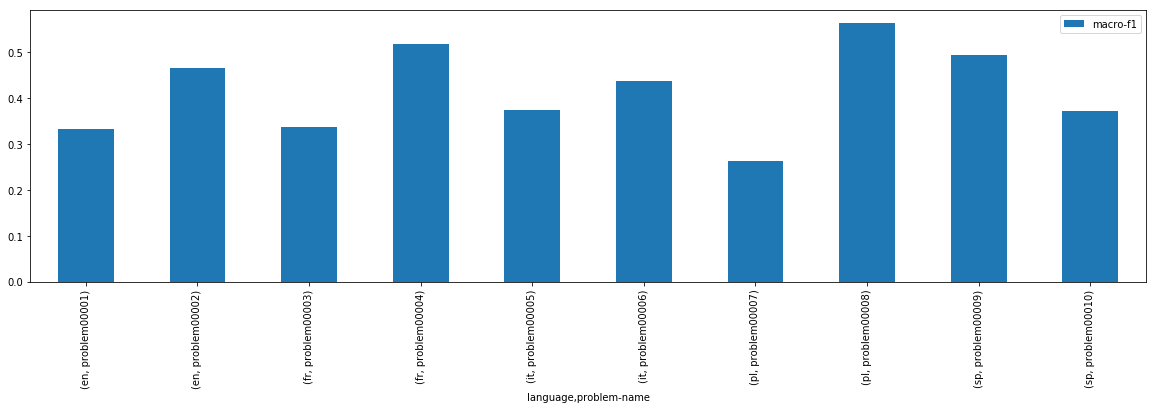

In [24]:
pd.DataFrame(result)\
    .sort_values(by=['language','problem-name'])[['language','problem-name','macro-f1']]\
    .plot(kind='bar', x=['language','problem-name'], legend=True, figsize=(20,5))

<br/><br/><br/><br/><br/>

#  Abordagem desafiante 1

In [25]:
from sklearn.metrics import pairwise_distances;

In [26]:
class DistanceTransformer(BaseEstimator):
    """Convert a sparse array into a dense array."""

    def __init__(self,
                analyzer='char',
                min_df=0.05,
                max_df=1.0,
                ngram_range=(2,5),
                lowercase=False,
                norm='l2',
                sublinear_tf=True,
                distance='cosine'):

            self.analyzer=analyzer;
            self.min_df=min_df;
            self.max_df=max_df;
            self.ngram_range=ngram_range;
            self.lowercase=lowercase;
            self.norm=norm;
            self.sublinear_tf=sublinear_tf
            self.distance = distance;
            

    def fit(self, X, y):
        self.vectorizer_ = TfidfVectorizer(
                analyzer=self.analyzer,
                min_df=self.min_df,
                max_df=self.max_df,
                ngram_range=self.ngram_range,
                lowercase=self.lowercase,
                norm=self.norm,
                sublinear_tf=self.sublinear_tf);
        
        #building the internal vocabulary
        self.vectorizer_.fit(X);
        
        #creating author profile
        profile = defaultdict(unicode);
        for text, label in zip(train_docs,train_labels):
            profile[label]+=text;
        
        #make sure the labels are going to be sorted
        self.profileLabels_ = set(profile.keys());
        x = [ profile[label] for label in self.profileLabels_]
            
        self.profileVector_ = self.vectorizer_.transform(x);
        
        return self;

    def transform(self, X, y=None):
        X = self.vectorizer_.transform(X);
        XD = pairwise_distances(X.todense(), self.profileVector_.todense(), metric = self.distance);
        return XD;

    def fit_transform(self, X, y):
        self.fit(X,y);
        return self.transform(X=X, y=y)

In [27]:
distancesList =['cosine',  'l1', 'l2',  'braycurtis', 'canberra',  'hamming', 'jaccard','rogerstanimoto','yule']

In [28]:
problem = problems[0];
print ("Problem: %s,  language: %s, " %(problem['problem'],problem['language']))

Problem: problem00001,  language: en, 


In [29]:
train_docs, train_labels,_ = zip(*problem['candidates']);

In [30]:
#code from baseline
gt = {}
with open(pathjoin(inputDir, problem['problem'], 'ground-truth.json'), 'r') as f:
    for attrib in json.load(f)['ground_truth']:
        gt[attrib['unknown-text']] = attrib['true-author']

In [31]:
test_docs, _, test_filename = zip(*problem['unknown'])
test_labels = [gt[v] for v in test_filename]

In [32]:
vect = DistanceTransformer();
vect.fit(train_docs,train_labels);

In [33]:
results = [];
clf = LogisticRegression(random_state=0,multi_class='multinomial', solver='newton-cg')

for distance in distancesList:
    print(distance)
    vect.distance = distance;
    trainx = vect.transform(train_docs);
    testx  = vect.transform(test_docs);

    clf.fit(trainx,train_labels);
    test_pred =clf.predict(testx);
    f1,precision,recall,accuracy =  eval_measures(gt,{k: v for k,v in zip(test_filename, test_pred)  })
    results.append({ 'caso' :distance,
                    'problem-name'   : problem['problem'],
                    'macro-f1'       : round(f1,3),
                    'macro-precision': round(precision,3),
                    'macro-recall'   : round(recall,3),
                    'micro-accuracy' : round(accuracy,3)
                 })

cosine
l1
l2
braycurtis
canberra
hamming
jaccard


/Users/joseeleandrocustodio/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


rogerstanimoto
yule


In [90]:
trainx.argmin(axis=1)

array([ 2,  2,  2,  2,  2,  2,  2,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,
        0,  0,  0,  0,  7,  7,  7,  7,  7,  7,  7,  6,  6,  6,  6,  6,  6,
        6,  5,  5,  5,  5,  5,  5,  5,  4,  4,  4,  4,  4,  4,  4, 10, 10,
       10, 10, 10, 10, 10,  9,  9,  9,  9,  9,  9,  9, 17, 17, 17, 17, 17,
       17, 17, 18, 18, 18, 18, 18, 18, 18, 16, 16, 16, 16, 16, 16, 16, 15,
       15, 15, 15, 15, 15, 15,  3,  3,  3,  3,  3,  3,  3, 19, 19, 19, 19,
       19, 19, 19, 12, 12, 12, 12, 12, 12, 12, 14, 14, 14, 14, 14, 14, 14,
       11, 11, 11, 11, 11, 11, 11, 13, 13, 13, 13, 13, 13, 13,  8,  8,  8,
        8,  8,  8,  8])

In [87]:
trainx[0]

array([0.46480313, 0.51840484, 0.        , 0.51873043, 0.41111525,
       0.50832317, 0.43716165, 0.48598719, 0.43087515, 0.52477813,
       0.40349086, 0.47411176, 0.47522962, 0.46993962, 0.46037501,
       0.49859737, 0.4323269 , 0.5033484 , 0.51500299, 0.54206009])

In [82]:
t=1-np.exp(trainx)/np.exp(trainx).sum(axis=1,keepdims=True)

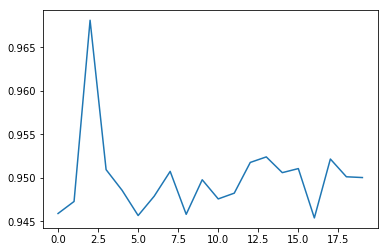

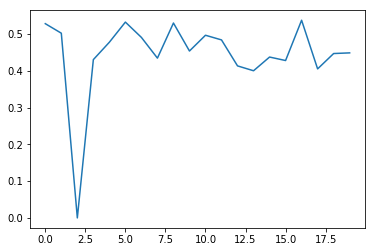

In [83]:
plt.plot(t[3])
plt.show()
plt.plot(trainx[3])

In [ ]:
metrics.pairwise_distances_argmin_min(X, Y)

In [36]:
pd.DataFrame(results).sort_values('macro-f1',ascending=False)

,caso,macro-f1,macro-precision,macro-recall,micro-accuracy,problem-name
1,l1,0.589,0.598,0.688,0.524,problem00001
4,canberra,0.456,0.456,0.574,0.524,problem00001
2,l2,0.334,0.345,0.464,0.419,problem00001
0,cosine,0.326,0.352,0.455,0.400,problem00001
8,yule,0.323,0.350,0.455,0.400,problem00001
7,rogerstanimoto,0.307,0.369,0.407,0.352,problem00001
3,braycurtis,0.288,0.363,0.388,0.371,problem00001
5,hamming,0.211,0.277,0.346,0.314,problem00001
6,jaccard,0.178,0.276,0.234,0.248,problem00001


In [63]:
def runML(problem):
    print ("\n\nProblem: %s,  language: %s, " %(problem['problem'],problem['language']))
    train_docs, train_labels,_ = zip(*problem['candidates']);
    #code from baseline
    gt = {}
    with open(pathjoin(inputDir, problem['problem'], 'ground-truth.json'), 'r') as f:
        for attrib in json.load(f)['ground_truth']:
            gt[attrib['unknown-text']] = attrib['true-author']
            
    test_docs, _, test_filename = zip(*problem['unknown'])
    test_labels = [gt[v] for v in test_filename]
    
    
    results = [];

    vect = DistanceTransformer(min_df=0.1);
    vect.fit(train_docs,train_labels);
    
    

    clf = Pipeline([
        ('normalizer', Normalizer()),
        ('scaler',MaxAbsScaler()),
        ('clf', LogisticRegression(random_state=0))
    ])

    for distance in distancesList:
        print(distance)
        vect.distance = distance;
        trainx = vect.transform(train_docs);
        testx  = vect.transform(test_docs);

        clf.fit(trainx,train_labels);
        test_pred =clf.predict(testx);
        f1,precision,recall,accuracy =  eval_measures(gt,{k: v for k,v in zip(test_filename, test_pred)  })
        results.append({ 'caso' :distance,
                        'problem-name'   : problem['problem'],
                        'macro-f1'       : round(f1,3),
                        'macro-precision': round(precision,3),
                        'macro-recall'   : round(recall,3),
                        'micro-accuracy' : round(accuracy,3)
                     })
    return results;

In [64]:
results =[t
    for problem in problems for t in runML(problem)];




Problem: problem00001,  language: en, 
cosine
l1
l2
braycurtis
canberra
hamming
jaccard
rogerstanimoto
yule


Problem: problem00002,  language: en, 
cosine
l1
l2
braycurtis
canberra
hamming
jaccard
rogerstanimoto
yule


Problem: problem00003,  language: fr, 
cosine
l1
l2
braycurtis
canberra
hamming
jaccard
rogerstanimoto
yule


Problem: problem00004,  language: fr, 
cosine
l1
l2
braycurtis
canberra
hamming
jaccard
rogerstanimoto
yule


Problem: problem00005,  language: it, 
cosine
l1
l2
braycurtis
canberra
hamming
jaccard
rogerstanimoto
yule


Problem: problem00006,  language: it, 
cosine
l1
l2
braycurtis
canberra
hamming
jaccard
rogerstanimoto
yule


Problem: problem00007,  language: pl, 
cosine
l1
l2
braycurtis
canberra
hamming
jaccard
rogerstanimoto
yule


Problem: problem00008,  language: pl, 
cosine
l1
l2
braycurtis
canberra
hamming
jaccard
rogerstanimoto
yule


Problem: problem00009,  language: sp, 
cosine
l1
l2
braycurtis
canberra
hamming
jaccard
rogerstanimoto
yule


Problem:

In [65]:
df= pd.DataFrame(results)

In [66]:
import seaborn as sns

df2= df[['macro-f1','caso','problem-name']].pivot(index='problem-name', columns='caso', values='macro-f1').reset_index()
cm = sns.light_palette("green", as_cmap=True)
df2=df2.style.background_gradient(cmap=cm,axis=1)
df2

caso,problem-name,braycurtis,canberra,cosine,hamming,jaccard,l1,l2,rogerstanimoto,yule
0,problem00001,0.381,0.258,0.41,0.244,0.229,0.394,0.395,0.226,0.316
1,problem00002,0.49,0.49,0.467,0.528,0.564,0.49,0.467,0.564,0.509
2,problem00003,0.134,0.121,0.078,0.117,0.067,0.134,0.078,0.143,0.092
3,problem00004,0.295,0.365,0.271,0.336,0.261,0.295,0.271,0.333,0.252
4,problem00005,0.069,0.046,0.029,0.027,0.059,0.036,0.029,0.05,0.055
5,problem00006,0.25,0.274,0.249,0.252,0.23,0.245,0.249,0.278,0.265
6,problem00007,0.093,0.062,0.123,0.031,0.033,0.093,0.119,0.046,0.032
7,problem00008,0.27,0.254,0.14,0.474,0.33,0.27,0.14,0.457,0.299
8,problem00009,0.109,0.134,0.123,0.12,0.097,0.132,0.119,0.112,0.09
9,problem00010,0.163,0.213,0.1,0.258,0.185,0.141,0.1,0.183,0.2


In [45]:
import seaborn as sns

df2= df[['macro-f1','caso','problem-name']].pivot(index='problem-name', columns='caso', values='macro-f1').reset_index()
cm = sns.light_palette("green", as_cmap=True)
df2=df2.style.background_gradient(cmap=cm,axis=1)
df2

caso,problem-name,braycurtis,canberra,cosine,hamming,jaccard,l1,l2,rogerstanimoto,yule
0,problem00001,0.403,0.276,0.42,0.339,0.266,0.407,0.426,0.32,0.305
1,problem00002,0.543,0.561,0.519,0.487,0.498,0.543,0.519,0.444,0.519
2,problem00003,0.091,0.124,0.041,0.085,0.061,0.083,0.041,0.057,0.062
3,problem00004,0.402,0.385,0.37,0.263,0.324,0.309,0.37,0.299,0.28
4,problem00005,0.063,0.09,0.123,0.025,0.073,0.082,0.11,0.069,0.078
5,problem00006,0.194,0.267,0.173,0.248,0.271,0.21,0.172,0.255,0.277
6,problem00007,0.063,0.058,0.051,0.052,0.061,0.076,0.051,0.043,0.037
7,problem00008,0.151,0.36,0.151,0.193,0.133,0.194,0.151,0.333,0.187
8,problem00009,0.081,0.1,0.083,0.082,0.093,0.083,0.091,0.095,0.097
9,problem00010,0.139,0.165,0.127,0.154,0.139,0.139,0.127,0.159,0.162


In [180]:
r = np.exp(np.random.rand(2000)*5)

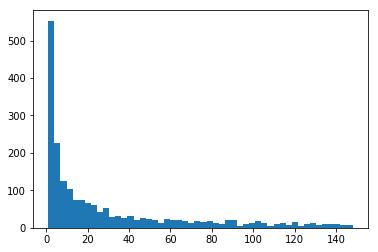

In [181]:
plt.hist(r, bins=50);

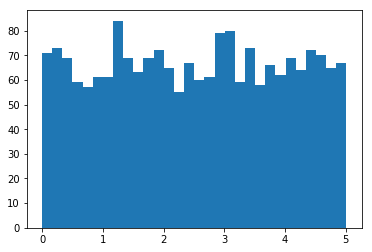

In [182]:
gamma =0.001
t = (r**gamma-1)/gamma
plt.hist(t,bins=30);

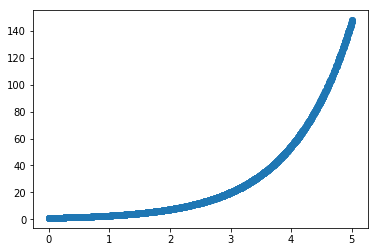

In [183]:
plt.scatter(x=t,y=r)